### Embedding visualization

In [33]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from data import get_dataset, get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels
from tensorflow.keras import optimizers
from sklearn.preprocessing import OrdinalEncoder
from train import SiameseModel
import json

In [66]:
data_dir = '/Users/gandhalimarunmale/Documents/02_Sem/Computer Vision/cv-project/siamese'

In [67]:
params = {
    'image_size': 256,
    'resize_pad': False,
    'dense_l2_reg_c': 0.0001,
    'embedding_size': 1,
    'lr': 0.001
}


#### Train images without augmentation on base model ResrNet50 weights

In [68]:
train_ds, N_train = get_dataset(get_ELEP_images_and_labels, 
                                params, 
                                str(Path(data_dir)/'classification'),
                                augment=False,  
                                cache_file=None, 
                                shuffle=False,
                                batch_size=32)

In [69]:
image_paths, image_labels = get_ELEP_images_and_labels(str(Path(data_dir)/'classification'))

In [70]:
enc = OrdinalEncoder()
l= np.array(image_labels).reshape(-1, 1)
enc.fit(l)
categories = enc.transform(l)

In [52]:
# image_paths, image_labels = get_zoo_elephants_images_and_labels(str(Path(data_dir)/'train'))
# y_true = (np.array(image_labels) == 'elephants').astype(np.int32)

In [71]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
embeddings = base_model.predict(train_ds)

In [72]:
embeddings.shape

(82, 2048)

In [73]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings)

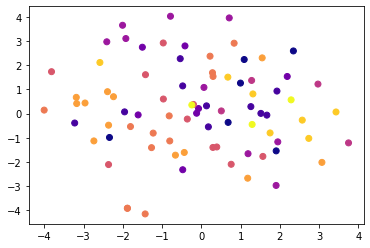

In [74]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=categories, cmap='plasma')

#### Train images without augmentation on base model InceptionV3 weights

In [75]:
base_model_inc = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
embeddings_inc = base_model_inc.predict(train_ds)

In [76]:
from sklearn.manifold import TSNE
X_embedded_inc = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_inc)

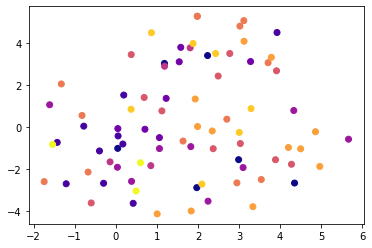

In [77]:
plt.scatter(X_embedded_inc[:,0], X_embedded_inc[:,1], c=categories, cmap='plasma')

#### Train images without augmentation on learned weights for ResNet50

In [31]:
!pwd

/Users/gandhalimarunmale/Documents/02_Sem/Computer Vision/cv-project/siamese


In [34]:
with open('hyperparameters/initial_run.json', 'rb') as f:
        params_siamese = json.load(f)

In [35]:
params_siamese

{'name': 'init',
 'image_size': 256,
 'resize_pad': False,
 'batch_size': {'train': 128, 'val': 512},
 'margin': 0.5,
 'squared': False,
 'embedding_size': 256,
 'lr': 5e-05,
 'decay_steps': 13,
 'decay_rate': 0.96,
 'dense_l2_reg_c': 0.01,
 'metrics_d': 1.25,
 'triplet_strategy': 'batch_all',
 'depthwise': False}

In [78]:
siamese_model = SiameseModel(params_siamese, False)

In [79]:
siamese_model.load_weights('best_weights')

In [42]:
siamese_model.summary()

Model: "siamese_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 256)               24089344  
                                                                 
Total params: 24,089,350
Trainable params: 524,544
Non-trainable params: 23,564,806
_________________________________________________________________


In [80]:
embeddings_siamese = siamese_model.predict(train_ds)

In [89]:
X_embedded_siamese = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_siamese)

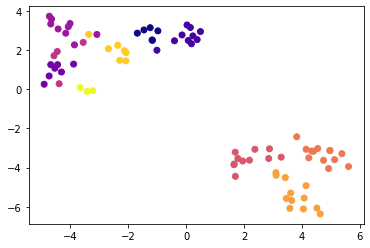

In [90]:
plt.scatter(X_embedded_siamese[:,0], X_embedded_siamese[:,1], c=categories, cmap='plasma')

#### Train images without augmentation on base model InceptionV3 weights

In [25]:
base_model_inc = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
embeddings_inc = base_model_inc.predict(train_ds)

87924736/87910968 [==============================] - 12s 0us/step


In [26]:
from sklearn.manifold import TSNE
X_embedded_inc = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_inc)

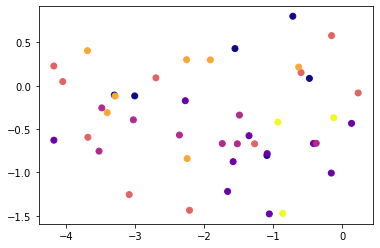

In [28]:
plt.scatter(X_embedded_inc[:,0], X_embedded_inc[:,1], c=categories, cmap='plasma')

## Images with resizepad

In [50]:
params = {
    'image_size': 256,
    'resize_pad': True,
    'dense_l2_reg_c': 0.0001,
    'embedding_size': 1,
    'lr': 0.001
}

cache_files = {
        'train': str(Path(data_dir) / 'train_resize.cache'),
        'val': str(Path(data_dir) / 'val_resize.cache')
}

In [51]:
train_ds, N_train = get_dataset(get_zoo_elephants_images_and_labels, 
                                params, 
                                str(Path(data_dir)/'train'),
                                augment=True,  
                                cache_file=cache_files['train'], 
                                shuffle=True,
                                batch_size=32)

val_ds, N_val = get_dataset(get_zoo_elephants_images_and_labels, 
                            params, 
                            str(Path(data_dir)/'val'),
                            augment=False, 
                            cache_file=cache_files['val'], 
                            shuffle=False, 
                            batch_size=32)

train_ds = train_ds.map(lambda x, y: (x, tf.cast(y == b'elephants', tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (x, tf.cast(y == b'elephants', tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE)